In [18]:
import os  
import numpy as np  
import torch  
from torch.utils.data import Dataset, DataLoader  
from scipy.ndimage import zoom  
import nibabel as nib  
from tqdm import tqdm  
import ast 
import pandas as pd

In [19]:
def load_folds_from_csv(csv_path):  
    """  
    Load fold data from a CSV file. 
    Args:  
        csv_path (str): CSV file path. 
    Returns:  
        folds (list): List of fold data.  
    """  
    df = pd.read_csv(csv_path)  
    folds = []  
    for _, row in df.iterrows():  
        fold_data = {  
            "train_images": ast.literal_eval(row["train_images"]),  
            "train_labels": ast.literal_eval(row["train_labels"]),  
            "val_images": ast.literal_eval(row["val_images"]),  
            "val_labels": ast.literal_eval(row["val_labels"]),  
        }  
        folds.append(fold_data)  
    return folds  

In [20]:
def preprocess_and_save(dataset_dir, output_dir, list_IDs, time_length=60, stride=3):  
    """  
    Modified preprocessing of fMRI data with more conservative parameters.  
    """  
    os.makedirs(output_dir, exist_ok=True)  
    
    # 计算整个数据集的统计信息用于标准化  
    all_means = []  
    all_stds = []  
    
    # for img_id in tqdm(list_IDs, desc="Calculating dataset statistics"):  
    #     img_path = os.path.join(dataset_dir, img_id)  
    #     img = nib.load(img_path).get_fdata()  
    #     all_means.append(np.mean(img))  
    #     all_stds.append(np.std(img))  
    
    global_mean = 127.997749335479 
    global_std = 205.58405261104812   
    print(global_mean, global_std)
    
    for img_id in tqdm(list_IDs, desc="Preprocessing fMRI data"):  
        output_path = os.path.join(output_dir, f"{img_id}.npy")  
        
        if os.path.exists(output_path):  
            tqdm.write(f"Skipping {img_id}: already processed.")  
            continue  
            
        # 加载图像  
        img_path = os.path.join(dataset_dir, img_id)  
        img = nib.load(img_path).get_fdata()  
        
        assert img.ndim == 4, f"Expected 4D fMRI data, but got {img.ndim}D"  
        
        # 1. 时间序列去趋势 - 使用更低阶的多项式  
        # for x in range(img.shape[0]):  
        #     for y in range(img.shape[1]):  
        #         for z in range(img.shape[2]):  
        #             signal = img[x, y, z, :]  
        #             detrended = signal - np.polynomial.polynomial.polyfit(  
        #                 np.arange(len(signal)), signal, deg=1  # 改为1阶  
        #             )[0]  
        #             img[x, y, z, :] = detrended  
        
        # # 2. 带通滤波 - 调整频率范围和阶数  
        # from scipy.signal import butter, filtfilt  
        
        # def butter_bandpass_filter(data, lowcut=0.01, highcut=0.1, fs=1.0, order=3):  
        #     nyq = 0.5 * fs  
        #     low = lowcut / nyq  
        #     high = highcut / nyq  
        #     b, a = butter(order, [low, high], btype='band')  
        #     return filtfilt(b, a, data)  
        
        # for x in range(img.shape[0]):  
        #     for y in range(img.shape[1]):  
        #         for z in range(img.shape[2]):  
        #             img[x, y, z, :] = butter_bandpass_filter(img[x, y, z, :])  
        
        # 3. 全局信号回归 - 添加平滑处理  
        from scipy.ndimage import gaussian_filter  
        global_signal = np.mean(img, axis=(0, 1, 2))  
        global_signal = gaussian_filter(global_signal, sigma=1.0)  
        for t in range(img.shape[3]):  
            img[:, :, :, t] = img[:, :, :, t] - global_signal[t]  
        
        # 4. 温和的Z-score标准化  
        img = (img - global_mean) / (global_std + 1e-6)  # 添加小量防止除零  
        
        total_timepoints = img.shape[3]  
        start_indices = range(0, total_timepoints - (time_length - 1) * stride, stride)  
        
        if len(start_indices) < time_length:  
            tqdm.write(  
                f"Warning: Not enough timepoints for {time_length} segments with stride {stride}. "  
                f"Using available timepoints and adding padding."  
            )  
            start_indices = list(range(0, total_timepoints, stride))  
            while len(start_indices) < time_length:  
                start_indices.append(total_timepoints - 1)  
        
        # 5. 提取片段并进行空间重采样 - 使用更保守的插值方法  
        all_segments = np.zeros((time_length, 64, 64, 64, 1))  
        
        for i, start_idx in enumerate(start_indices[:time_length]):  
            segment = img[:, :, :, start_idx]  
            
            # 使用线性插值而不是三次样条  
            scale_factors = (64/segment.shape[0], 64/segment.shape[1], 64/segment.shape[2])  
            resized_segment = zoom(segment, scale_factors, order=1)  # 改为线性插值  
            
            # 6. 更温和的对比度增强  
            from skimage.exposure import rescale_intensity  
            p2, p98 = np.percentile(resized_segment, (0.5, 99.5))  
            resized_segment = rescale_intensity(resized_segment, in_range=(p2, p98), out_range=(-1, 1))  
            
            # 可选：添加轻微的高斯平滑以减少噪声  
            resized_segment = gaussian_filter(resized_segment, sigma=0.5)  
            
            all_segments[i, :, :, :, 0] = resized_segment  
        
        # 7. 最终的温和标准化  
        all_segments = (all_segments - np.mean(all_segments)) / (np.std(all_segments) + 1e-6)  
        
        # # 8. 限制极值  
        # all_segments = np.clip(all_segments, -3, 3)  
        
        np.save(output_path, all_segments)  
        tqdm.write(f"Processed {img_id}: saved {time_length} segments with shape (60, 64, 64, 64, 1)")

In [21]:
def visualize_preprocessing(dataset_dir, processed_file, slice_idx=None, time_point=0):  
    """  
    Enhanced visualization of fMRI data before and after preprocessing.  
    
    Args:  
        dataset_dir (str): Directory containing the original fMRI file  
        processed_file (str): Path to the processed .npy file  
        slice_idx (dict, optional): Dictionary with custom slice indices for each view  
        time_point (int): Time point to visualize (default=0)  
    """  
    import matplotlib.pyplot as plt  
    import nibabel as nib  
    import numpy as np  
    from matplotlib.gridspec import GridSpec  
    from matplotlib.colors import LinearSegmentedColormap  
    
    # 创建自定义颜色映射  
    colors = ['black', '#1a1a1a', '#4d4d4d', '#808080', '#cccccc', 'white']  
    n_bins = 256  
    custom_cmap = LinearSegmentedColormap.from_list('custom_gray', colors, N=n_bins)  
    
    # 加载数据  
    orig_img_id = processed_file.split('/')[-1].replace('.npy', '')  
    orig_img_path = os.path.join(dataset_dir, orig_img_id)  
    orig_data = nib.load(orig_img_path).get_fdata()  
    processed_data = np.load(processed_file)  
    
    # 设置切片索引  
    if slice_idx is None:  
        slice_idx = {  
            'axial': orig_data.shape[2] // 2,  
            'coronal': orig_data.shape[1] // 2,  
            'sagittal': orig_data.shape[0] // 2  
        }  
    
    # 创建高分辨率图形  
    plt.figure(figsize=(20, 14), dpi=150)  
    gs = GridSpec(2, 3, height_ratios=[1, 1], hspace=0.3, wspace=0.3)  
    
    # 设置标题  
    plt.suptitle('fMRI Data: Before vs After Preprocessing', fontsize=20, y=0.95)  
    
    views = ['Axial', 'Coronal', 'Sagittal']  
    slices = [  
        (slice_idx['axial'], lambda x: x[:, :, slice_idx['axial'], time_point]),  
        (slice_idx['coronal'], lambda x: x[:, slice_idx['coronal'], :, time_point]),  
        (slice_idx['sagittal'], lambda x: x[slice_idx['sagittal'], :, :, time_point])  
    ]  
    
    def enhance_contrast(img):  
        """增强图像对比度"""  
        p2, p98 = np.percentile(img, (2, 98))  
        return np.clip((img - p2) / (p98 - p2), 0, 1)  
    
    for idx, (view, (slice_pos, slice_func)) in enumerate(zip(views, slices)):  
        # 原始数据  
        ax = plt.subplot(gs[0, idx])  
        orig_slice = slice_func(orig_data)  
        orig_slice = enhance_contrast(orig_slice)  
        
        im = ax.imshow(orig_slice, cmap=custom_cmap, interpolation='nearest')  
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  
        cbar.ax.tick_params(labelsize=10)  
        
        ax.set_title(f'Original - {view} View', fontsize=14, pad=10)  
        ax.axis('off')  
        
        # 添加解剖学方向标记  
        if view == 'Axial':  
            ax.text(0.02, 0.98, 'A', transform=ax.transAxes, fontsize=12, va='top')  
            ax.text(0.98, 0.98, 'P', transform=ax.transAxes, fontsize=12, va='top', ha='right')  
            ax.text(0.02, 0.02, 'L', transform=ax.transAxes, fontsize=12)  
            ax.text(0.98, 0.02, 'R', transform=ax.transAxes, fontsize=12, ha='right')  
        
        # 处理后数据  
        ax = plt.subplot(gs[1, idx])  
        proc_slice = processed_data[time_point, :, :, :, 0]  
        
        if view == 'Axial':  
            proc_slice = proc_slice[:, :, proc_slice.shape[2]//2]  
        elif view == 'Coronal':  
            proc_slice = proc_slice[:, proc_slice.shape[1]//2, :]  
        else:  # Sagittal  
            proc_slice = proc_slice[proc_slice.shape[0]//2, :, :]  
        
        proc_slice = enhance_contrast(proc_slice)  
        
        im = ax.imshow(proc_slice, cmap=custom_cmap, interpolation='nearest')  
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  
        cbar.ax.tick_params(labelsize=10)  
        
        ax.set_title(f'Processed - {view} View', fontsize=14, pad=10)  
        ax.axis('off')  
        
        # 添加比例尺  
        if idx == 0:  
            scalebar_length = 20  # 像素数  
            scalebar_width = 2  
            ax.plot([10, 10 + scalebar_length],   
                   [proc_slice.shape[0] - 10, proc_slice.shape[0] - 10],   
                   'w-', linewidth=scalebar_width)  
            ax.text(10, proc_slice.shape[0] - 20,   
                   f'{scalebar_length} pixels',   
                   color='white', fontsize=10)  
    
    # 添加处理信息  
    plt.figtext(0.02, 0.02,   
                f'Time point: {time_point}\nImage ID: {orig_img_id}',   
                fontsize=10, ha='left')  
    
    plt.tight_layout()
    plt.savefig('fmri_preprocessing_comparison.png', dpi=300, bbox_inches='tight') 
    return plt.gcf()  

# 使用示例：  
# fig = visualize_preprocessing(dataset_dir, processed_file)  
# fig.savefig('fmri_preprocessing_comparison.png', dpi=300, bbox_inches='tight')  
# plt.close()

In [22]:

raw_dataset_dir = "/root/autodl-tmp/CNNLSTM/Project/Data"  # Original .nii files directory  
preprocessed_dir = "/root/autodl-tmp/CNNLSTM/Project/preprocssed_test"  # Preprocessed .npy files directory  
csv_path = "/root/autodl-tmp/CNNLSTM/Project/fMRI/fold_data.csv"  # CSV file containing fold data  

folds = load_folds_from_csv(csv_path)  

all_images = set()  
for fold in folds:  
    all_images.update(fold["train_images"])  
    all_images.update(fold["val_images"])  
preprocess_and_save(raw_dataset_dir, preprocessed_dir, list(all_images), time_length=60)  



127.997749335479 205.58405261104812


Preprocessing fMRI data:   0%|          | 0/1024 [00:00<?, ?it/s]

Preprocessing fMRI data:   0%|          | 0/1024 [00:01<?, ?it/s]

Preprocessing fMRI data:   0%|          | 1/1024 [00:03<51:25,  3.02s/it]

Processed sub-0010042_ses-1_task-rest_run-1_bold.nii.gz: saved 60 segments with shape (60, 64, 64, 64, 1)


Preprocessing fMRI data:   0%|          | 1/1024 [00:04<51:25,  3.02s/it]

Preprocessing fMRI data:   0%|          | 2/1024 [00:05<51:01,  3.00s/it]

Processed sub-0010120_ses-1_task-rest_run-1_bold.nii.gz: saved 60 segments with shape (60, 64, 64, 64, 1)


Preprocessing fMRI data:   0%|          | 2/1024 [00:07<51:01,  3.00s/it]

Preprocessing fMRI data:   0%|          | 3/1024 [00:09<51:18,  3.02s/it]

Processed sub-3679455_ses-1_task-rest_run-1_bold.nii.gz: saved 60 segments with shape (60, 64, 64, 64, 1)


Preprocessing fMRI data:   0%|          | 3/1024 [00:09<51:18,  3.02s/it]

Preprocessing fMRI data:   0%|          | 4/1024 [00:10<44:02,  2.59s/it]

Processed sub-4072305_ses-1_task-rest_run-3_bold.nii.gz: saved 60 segments with shape (60, 64, 64, 64, 1)


Preprocessing fMRI data:   0%|          | 4/1024 [00:11<44:02,  2.59s/it]

Preprocessing fMRI data:   0%|          | 5/1024 [00:13<43:17,  2.55s/it]

Processed sub-1068505_ses-1_task-rest_run-1_bold.nii.gz: saved 60 segments with shape (60, 64, 64, 64, 1)


Preprocessing fMRI data:   0%|          | 5/1024 [00:13<46:40,  2.75s/it]


KeyboardInterrupt: 

/tmp/ipykernel_76151/1167365834.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


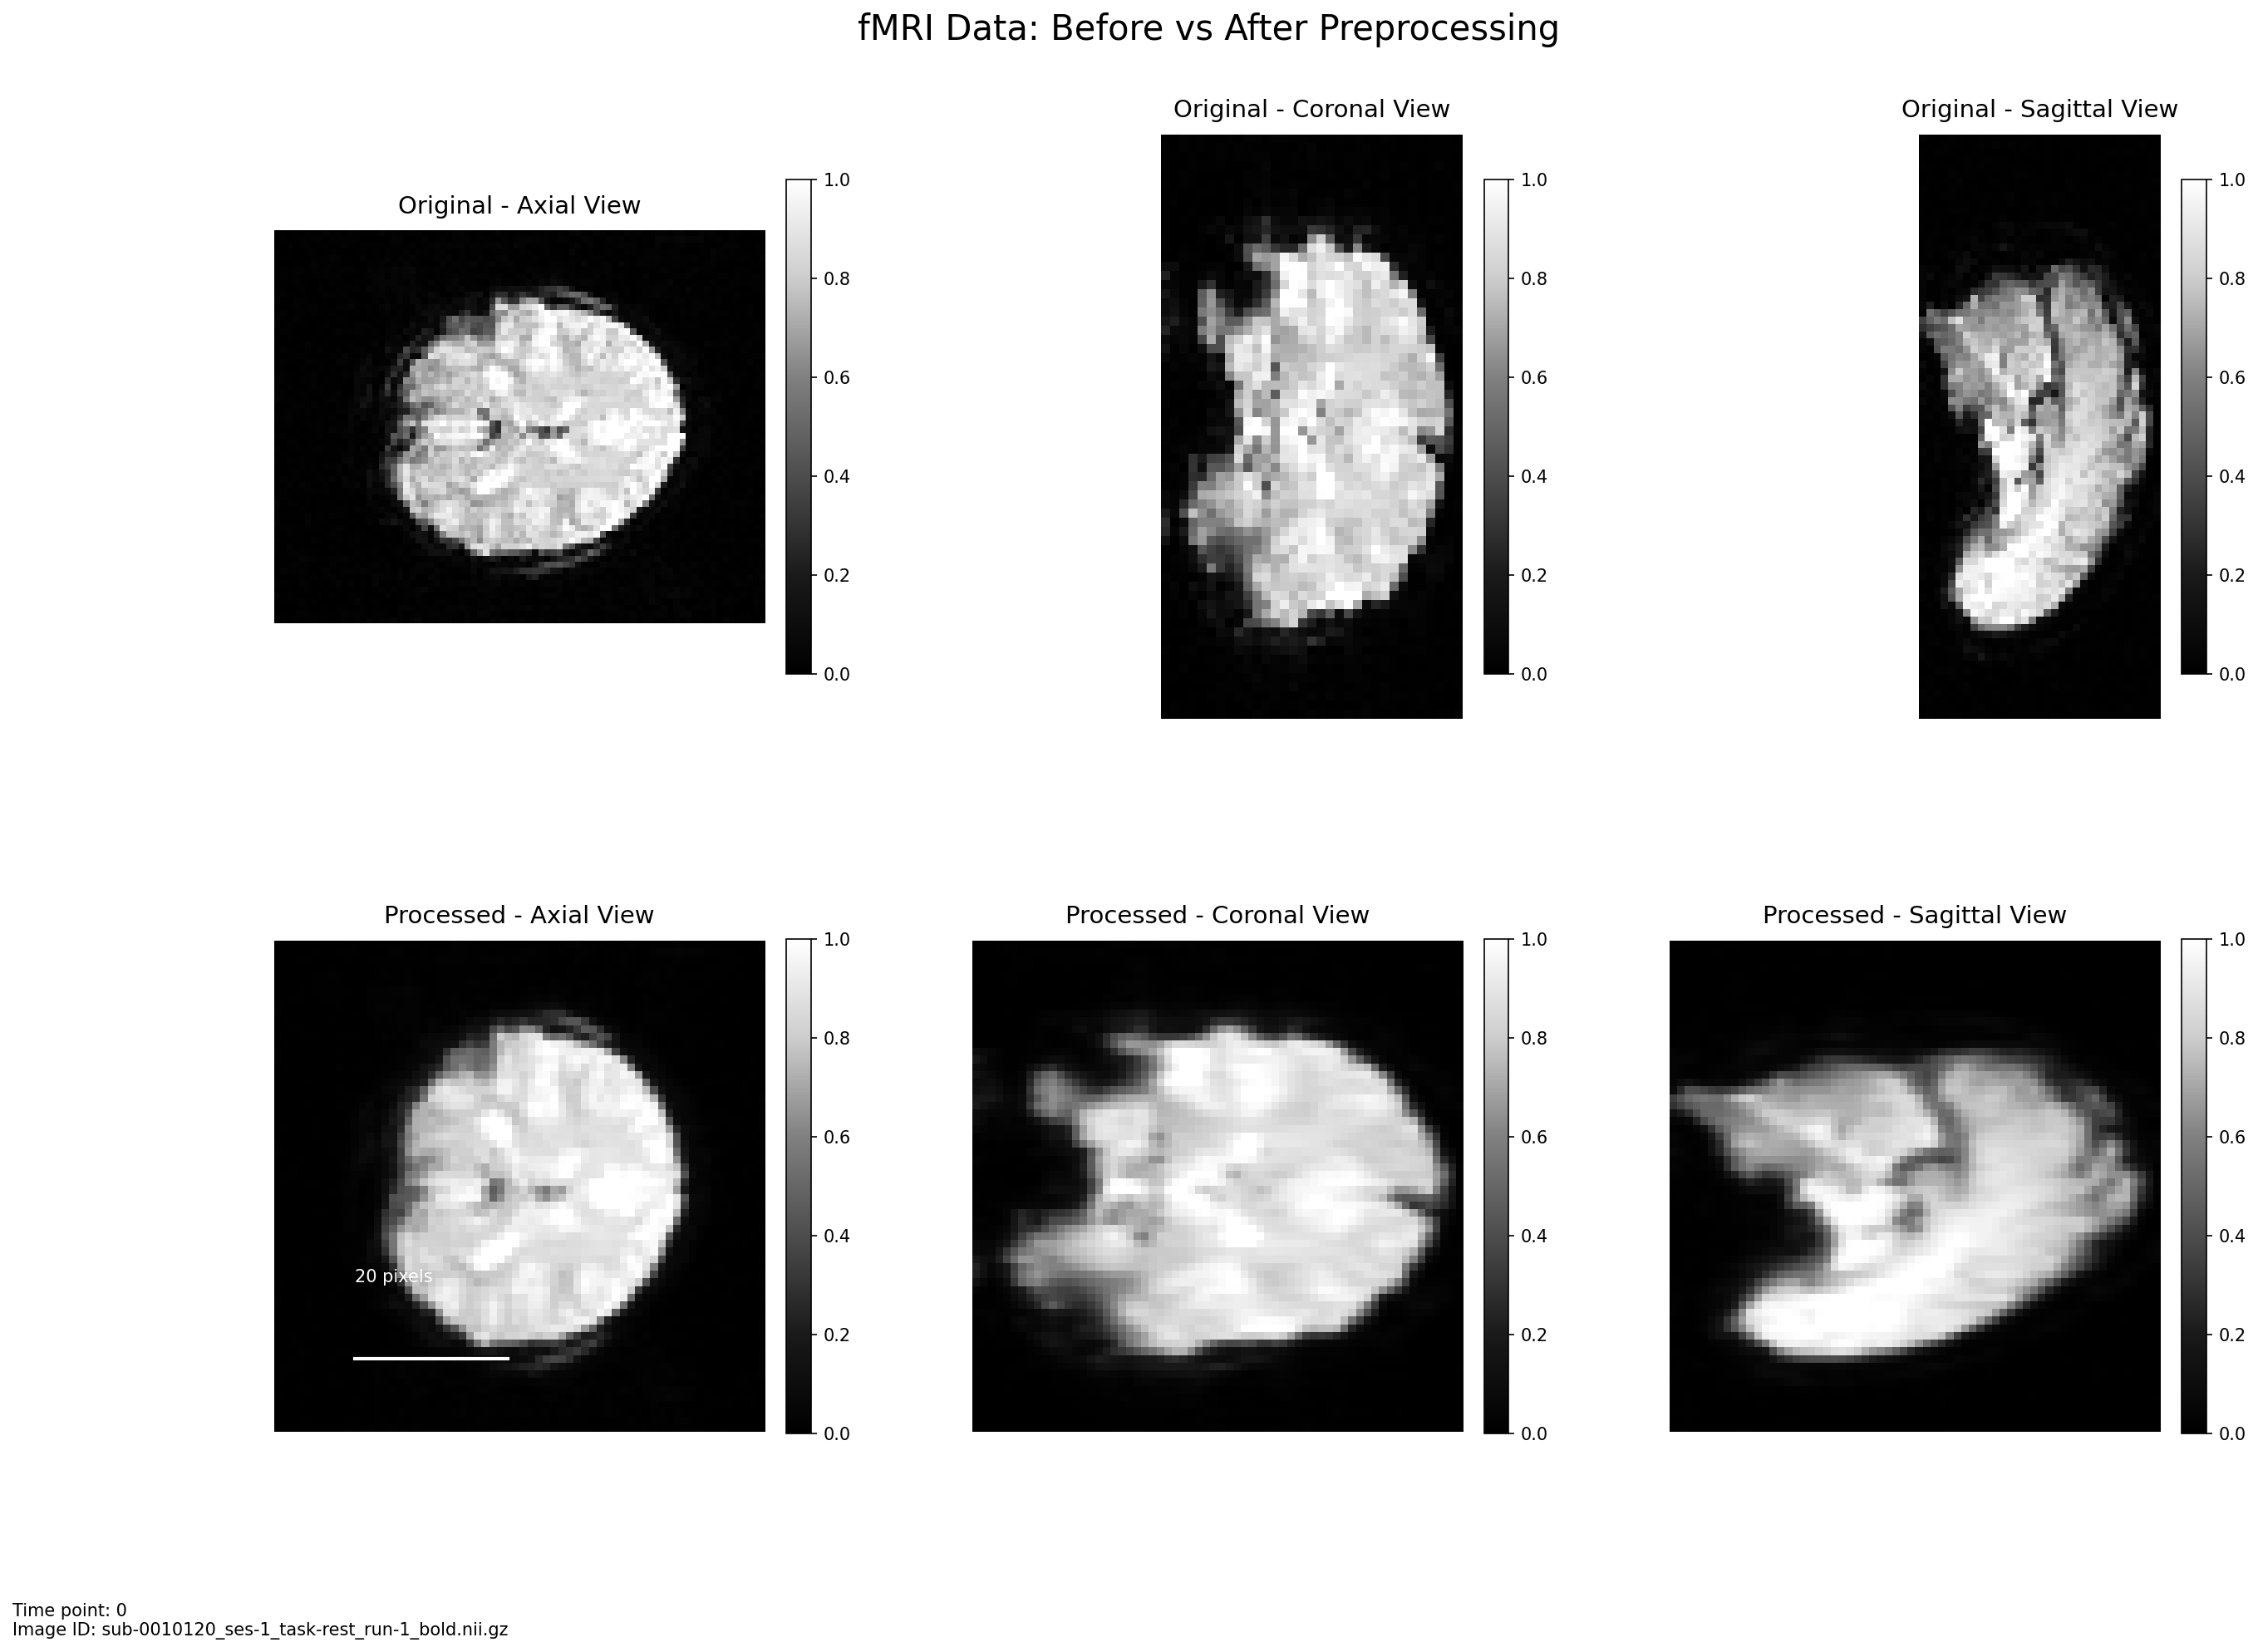

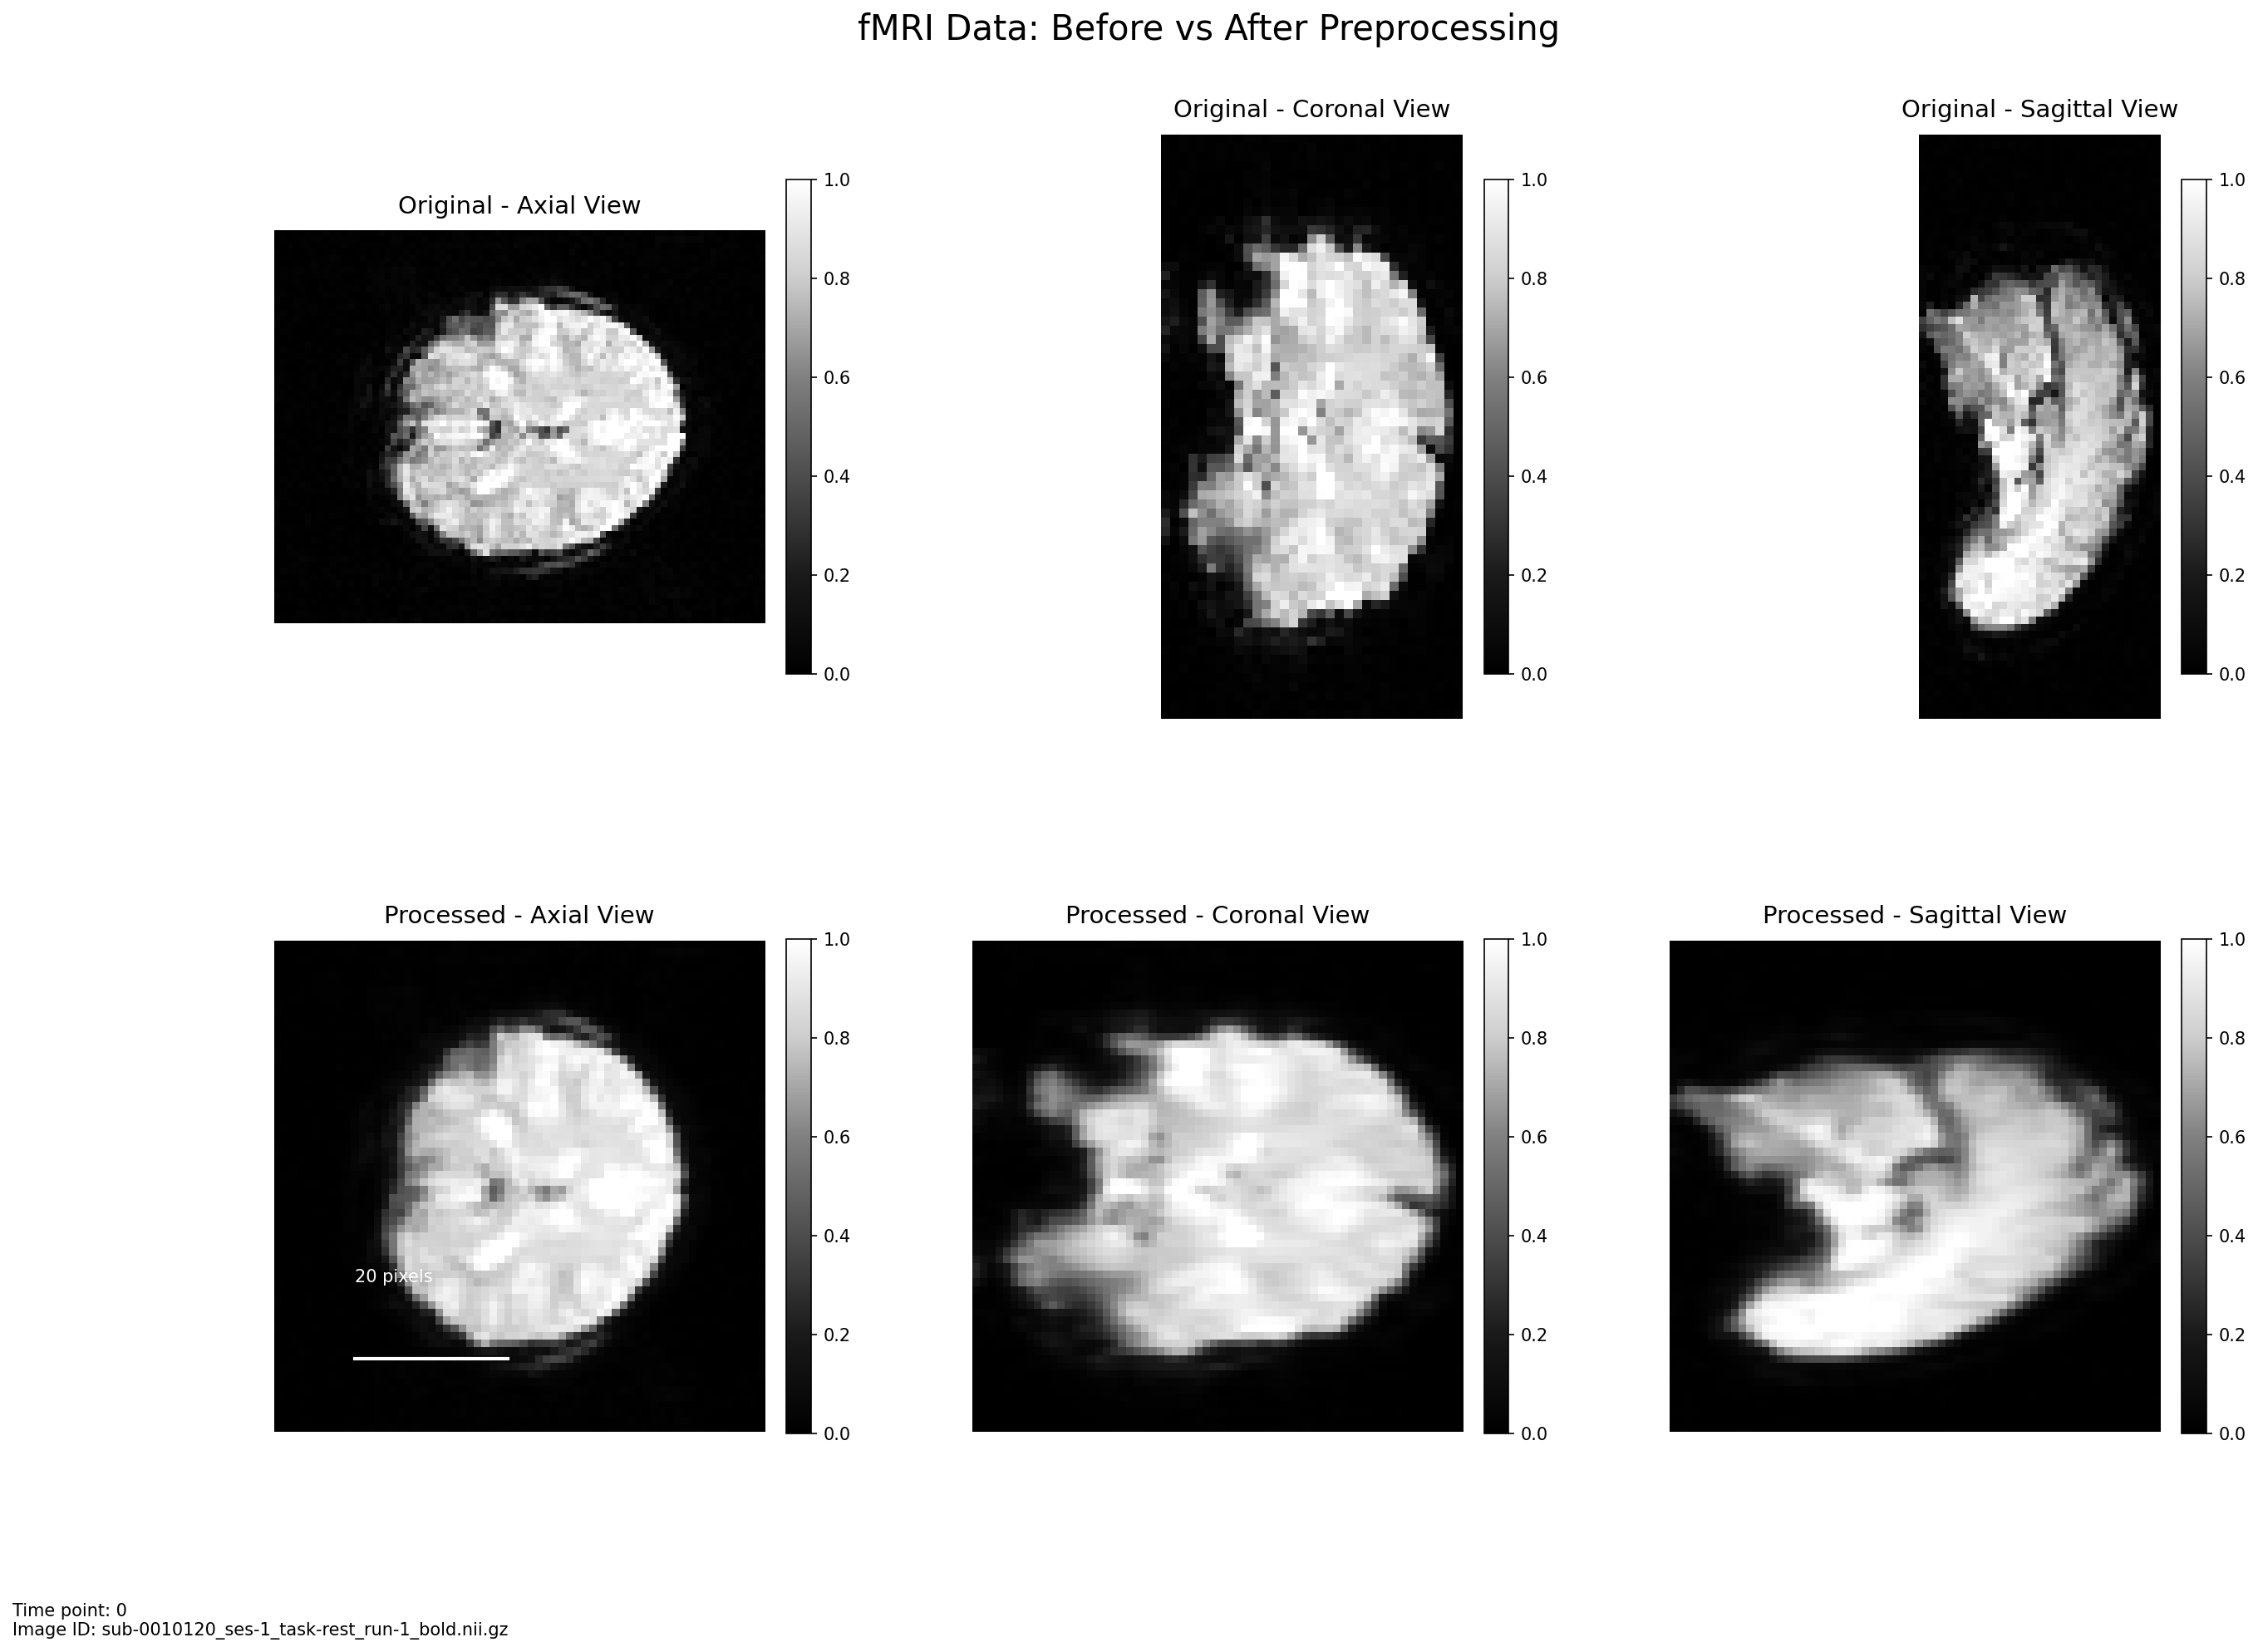

In [26]:
visualize_preprocessing(  
    dataset_dir='/root/autodl-tmp/CNNLSTM/Project/Data',  
    processed_file='/root/autodl-tmp/CNNLSTM/Project/preprocssed_test/sub-0010120_ses-1_task-rest_run-1_bold.nii.gz.npy',  
    time_point=0  
)

In [1]:
import os  
import numpy as np  
import torch  
from torch.utils.data import Dataset, DataLoader  
from tqdm import tqdm  
import nibabel as nib  
import matplotlib.pyplot as plt  
import seaborn as sns  
import time

class fMRIDataset(Dataset):  
    def __init__(self, root_dir, transform=None):  
        """  
        参数:  
        root_dir (string): 数据目录路径  
        transform (callable, optional): 可选的数据转换  
        """  
        self.root_dir = root_dir  
        self.transform = transform  
        self.file_list = []  
        self.labels = []  
        
        # 遍历目录获取所有.npy文件  
        for file in os.listdir(root_dir):  
            if file.endswith('.npy'):  
                self.file_list.append(file)  
                # 从文件名中提取标签（假设rest为0，task为1）  
                label = 1 if 'task' in file else 0  
                self.labels.append(label)  
                
    def __len__(self):  
        return len(self.file_list)  
    
    def __getitem__(self, idx):  
        # 加载.npy文件  
        file_path = os.path.join(self.root_dir, self.file_list[idx])  
        data = np.load(file_path)  
        
        # 确保数据形状正确 [time_steps, height, width, depth]  
        if len(data.shape) != 4:  
            raise ValueError(f"Unexpected data shape: {data.shape}")  
        
        # 添加channel维度  
        data = data[..., np.newaxis]  
        
        # 转换为tensor  
        data = torch.FloatTensor(data)  
        label = torch.tensor(self.labels[idx])  
        
        if self.transform:  
            data = self.transform(data)  
            
        return data, label  

def analyze_dataset(root_dir):  
    """分析数据集的基本统计信息"""  
    print("开始数据集分析...")  
    
    # 统计文件数量和类别分布  
    rest_count = 0  
    task_count = 0  
    file_sizes = []  
    time_steps = []  
    voxel_values = []  
    
    for file in tqdm(os.listdir(root_dir), desc="分析文件"):  
        if file.endswith('.npy'):  
            file_path = os.path.join(root_dir, file)  
            
            # 统计文件大小  
            file_size = os.path.getsize(file_path) / (1024 * 1024)  # 转换为MB  
            file_sizes.append(file_size)  
            
            # 加载数据  
            data = np.load(file_path)  
            time_steps.append(data.shape[0])  
            
            # 采样一些体素值进行统计  
            sample_values = data.flatten()[:10000]  # 取前10000个值作为样本  
            voxel_values.extend(sample_values)  
            
            # 统计类别  
            if 'task' in file:  
                task_count += 1  
            else:  
                rest_count += 1  
    
    # 打印基本统计信息  
    print("\n=== 数据集统计信息 ===")  
    print(f"总文件数: {rest_count + task_count}")  
    print(f"Rest样本数: {rest_count}")  
    print(f"Task样本数: {task_count}")  
    print(f"\n文件大小统计(MB):")  
    print(f"平均: {np.mean(file_sizes):.2f}")  
    print(f"最小: {np.min(file_sizes):.2f}")  
    print(f"最大: {np.max(file_sizes):.2f}")  
    print(f"\n时间步长统计:")  
    print(f"平均: {np.mean(time_steps):.2f}")  
    print(f"最小: {np.min(time_steps)}")  
    print(f"最大: {np.max(time_steps)}")  
    
    # 绘制统计图  
    plt.figure(figsize=(15, 10))  
    
    # 文件大小分布  
    plt.subplot(2, 2, 1)  
    sns.histplot(file_sizes)  
    plt.title('文件大小分布(MB)')  
    plt.xlabel('文件大小(MB)')  
    plt.ylabel('数量')  
    
    # 时间步长分布  
    plt.subplot(2, 2, 2)  
    sns.histplot(time_steps)  
    plt.title('时间步长分布')  
    plt.xlabel('时间步长')  
    plt.ylabel('数量')  
    
    # 体素值分布  
    plt.subplot(2, 2, 3)  
    sns.histplot(voxel_values, bins=50)  
    plt.title('体素值分布')  
    plt.xlabel('体素值')  
    plt.ylabel('数量')  
    
    # 类别分布  
    plt.subplot(2, 2, 4)  
    plt.pie([rest_count, task_count], labels=['Rest', 'Task'], autopct='%1.1f%%')  
    plt.title('类别分布')  
    
    plt.tight_layout()  
    plt.savefig('dataset_analysis.png')  
    plt.close()  

def test_dataloader(root_dir, batch_size=1):  
    """测试数据加载器的性能"""  
    # 创建数据集和数据加载器  
    dataset = fMRIDataset(root_dir)  
    dataloader = DataLoader(  
        dataset,  
        batch_size=batch_size,  
        shuffle=True,  
        num_workers=4,  
        pin_memory=True  
    )  
    
    print("\n=== 测试数据加载器 ===")  
    print(f"数据集大小: {len(dataset)}")  
    print(f"批次大小: {batch_size}")  
    print(f"批次数量: {len(dataloader)}")  
    
    # 测试数据加载时间  
    start_time = time.time()  
    for i, (data, label) in enumerate(tqdm(dataloader, desc="测试数据加载")):  
        if i == 0:  
            print(f"\n第一批数据形状: {data.shape}")  
            print(f"标签形状: {label.shape}")  
            
        # 模拟简单处理  
        time.sleep(0.01)  
        
        if i >= 10:  # 只测试前10个批次  
            break  
            
    end_time = time.time()  
    print(f"\n加载10个批次用时: {end_time - start_time:.2f}秒")  

def main():  
    # 设置数据目录  
    root_dir = "/root/autodl-tmp/CNNLSTM/Project/preprocssed_60_64"  
    
    # 分析数据集  
    analyze_dataset(root_dir)  
    
    # 测试数据加载器  
    test_dataloader(root_dir, batch_size=1)  
    
    # 创建完整的数据加载器用于训练  
    train_dataset = fMRIDataset(root_dir)  
    train_loader = DataLoader(  
        train_dataset,  
        batch_size=1,  
        shuffle=True,  
        num_workers=4,  
        pin_memory=True,  
        prefetch_factor=2,  
        persistent_workers=True  
    )  
    
    return train_loader  

if __name__ == "__main__":  
    train_loader = main()

开始数据集分析...


分析文件: 100%|██████████| 1024/1024 [02:17<00:00,  7.46it/s]



=== 数据集统计信息 ===
总文件数: 1024
Rest样本数: 0
Task样本数: 1024

文件大小统计(MB):
平均: 120.00
最小: 120.00
最大: 120.00

时间步长统计:
平均: 60.00
最小: 60
最大: 60


/tmp/ipykernel_37089/1093626261.py:130: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_37089/1093626261.py:130: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_37089/1093626261.py:130: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_37089/1093626261.py:130: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_37089/1093626261.py:130: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_37089/1093626261.py:130: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_37089/1093626261.py:130: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.


=== 测试数据加载器 ===
数据集大小: 1024
批次大小: 1
批次数量: 1024


NameError: name 'time' is not defined

In [13]:
list1 = [0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1]
list2 = [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1]

In [16]:
c0 = 0
c1 = 0
for x in list1:
    if x == 0:
        c0 += 1
    else:
        c1 += 1
print(c0, c1)
for x in list2:
    if x==0:
        c0+=1
    else:
        c1+=1
print(c0, c1)


422 397
528 496


In [17]:
c0 =0
c1=0
for x in list2:
    if x==0:
        c0+=1
    else:
        c1+=1
print(c0, c1)

106 99


In [ ]:
import nibabel as nib  
import numpy as np  
import matplotlib.pyplot as plt  

# 加载NIfTI文件  
img = nib.load('/root/autodl-tmp/CNNLSTM/Project/Data/sub-0010001_ses-1_task-rest_run-1_bold.nii.gz')  

# 获取数据数组  
data = img.get_fdata()  

# 打印基本信息  
print("数据形状:", data.shape)  # 通常是(X, Y, Z, Time)格式  
print("数据类型:", data.dtype)  
print("头文件信息:")  
print(img.header)  

# 可视化中间切片的一个时间点  
def plot_middle_slice(data):  
    if len(data.shape) == 4:  
        # 如果是4D数据，取第一个时间点  
        middle_slice = data[:, :, data.shape[2]//2, 0]  
    else:  
        # 如果是3D数据  
        middle_slice = data[:, :, data.shape[2]//2]  
    
    plt.figure(figsize=(8, 8))  
    plt.imshow(middle_slice.T, cmap='gray')  
    plt.colorbar()  
    plt.title('Middle Slice')  
    plt.axis('off')  
    plt.show()  

# 显示中间切片  
plot_middle_slice(data)  

# 如果需要查看时间序列  
def plot_voxel_timeseries(data, x, y, z):  
    if len(data.shape) == 4:  
        timeseries = data[x, y, z, :]  
        plt.figure(figsize=(12, 4))  
        plt.plot(timeseries)  
        plt.title(f'Voxel Time Series at ({x}, {y}, {z})')  
        plt.xlabel('Time Point')  
        plt.ylabel('Signal Intensity')  
        plt.show()  

# 选择中心体素的时间序列  
if len(data.shape) == 4:  
    center_x = data.shape[0]//2  
    center_y = data.shape[1]//2  
    center_z = data.shape[2]//2  
    plot_voxel_timeseries(data, center_x, center_y, center_z)